In [2]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [3]:
def onehotify(tensor):
    vocab = {'A':'0','C':'1','G':'2','T':'3'}
    for key in vocab.keys():
        tensor = tf.strings.regex_replace(tensor, key, vocab[key])
    split = tf.strings.bytes_split(tensor)
    labels = tf.cast(tf.strings.to_number(split), tf.uint8)
    onehot = tf.one_hot(labels, 4)
    onehot = tf.reshape(onehot, (-1,))
    return onehot

In [10]:
train_dataset, test_dataset = tfds.load("genomics_ood",as_supervised=True,split=['train','test'])

train_dataset = train_dataset.take(100000)
test_dataset = test_dataset.take(1000)

train_dataset=train_dataset.map(lambda seq,label: (onehotify(seq),tf.one_hot(label, 10)))

train_dataset = train_dataset.batch(128)
train_dataset = train_dataset.shuffle(128)



test_dataset=test_dataset.map(lambda seq,label: (onehotify(seq),tf.one_hot(label, 10)))

test_dataset = test_dataset.batch(128)
test_dataset = test_dataset.shuffle(128)




In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the three layers.
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )
        self.hidden_layer_2 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )
        self.output_layer = tf.keras.layers.Dense(units=10,
                                               activation=tf.keras.activations.softmax
                                               )
    def call(self, x):
        # Define the forward step.
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.output_layer(x)
        return x

In [7]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy
  



In [11]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.1
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=128)
    test_dataset = test_dataset.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)



Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9


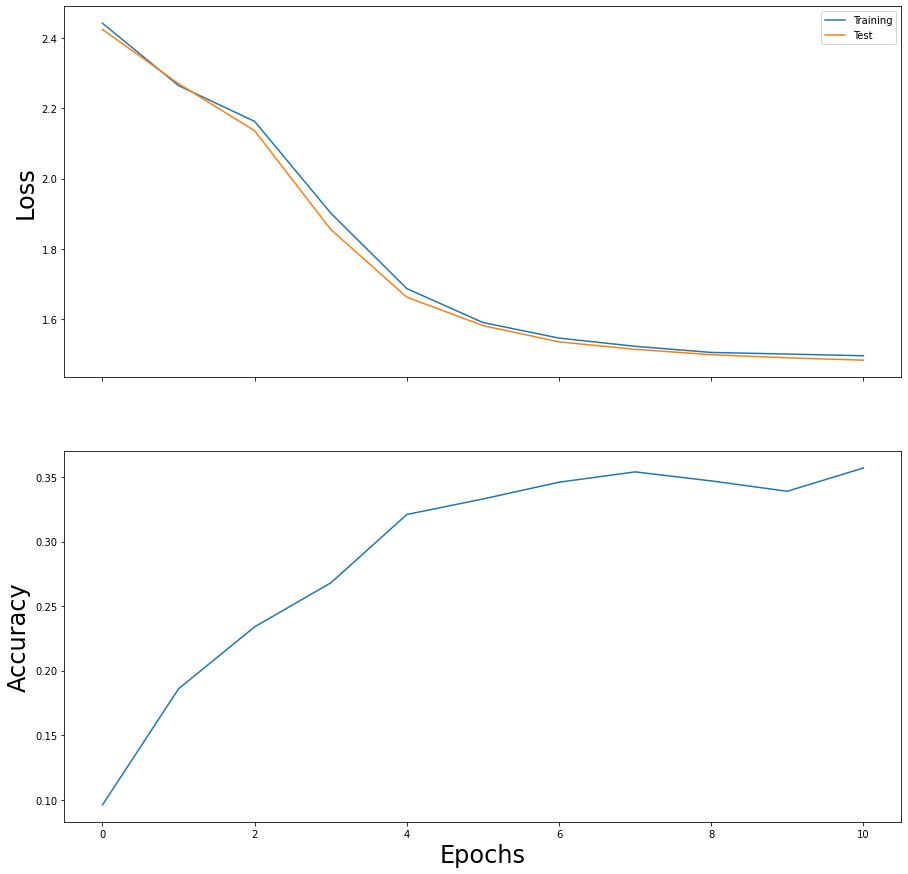

In [12]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
fig, ax = plt.subplots(2,1,sharex=True,figsize=(15,15))
ax[0].plot(train_losses,label="Training")
ax[0].plot(test_losses,label="Test")
fontsize=24
ax[0].set_ylabel("Loss",fontsize=fontsize)
ax[1].set_ylabel("Accuracy",fontsize=fontsize)
ax[1].set_xlabel("Epochs",fontsize=fontsize)
ax[1].plot(test_accuracies,label="test")
ax[0].legend()
plt.show()